In [ ]:
from google.colab import drive  
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Project DeepLearning/

/content/drive/.shortcut-targets-by-id/1km9M4i6LOWecmx744kzgiNqCS_VRs6g1/Project DeepLearning


## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

In [ ]:
!pip install -q tf-models-official

In [ ]:
!pip install vncorenlp

In [ ]:
pip install transformers

IMPORT THƯ VIỆN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import torch
import pickle
from vncorenlp import VnCoreNLP

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay

# Load Huggingface transformers
from transformers import *

# Then what you need from tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


SETUP BERT

In [ ]:
#######################################
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'vinai/phobert-base'

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFAutoModel.from_pretrained(model_name, config = config)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
MAX_SEQ_LEN = 250
number_topic =12

In [ ]:
def seq2inds(x) :
    x = tokenizer(
        text= x ,
        add_special_tokens=True,
        max_length=MAX_SEQ_LEN,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)
    return x['input_ids'].numpy().tolist()

## LOAD DATA



In [ ]:
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

def get_data(raw_text):
    x = []
    temp_x = raw_text
    
    for sample in temp_x :        
        sample = rdrsegmenter.tokenize(sample) 
        sample = ' '.join([' '.join(word) for word in sample])
        x.append(sample)
    x = seq2inds(x)
    return x

Load dữ liệu

In [ ]:
data_train = pickle.load(open('Data/data_train.pkl', 'rb'))
data_test = pickle.load(open('Data/data_test.pkl', 'rb'))
target_train = pickle.load(open('Data/target_train.pkl', 'rb'))
target_test = pickle.load(open('Data/target_test.pkl', 'rb'))

In [ ]:
x_train= get_data(data_train[:5000])
x_test= get_data(data_test)
y_train = pd.get_dummies(target_train[:5000]).values.tolist()
y_test = pd.get_dummies(target_test).values.tolist()

In [ ]:
pickle.dump(x_train, open('PhoBERT/x_train.pkl', 'wb'))
pickle.dump(y_train, open('PhoBERT/y_train.pkl', 'wb'))
pickle.dump(x_test, open('PhoBERT/x_test.pkl', 'wb'))
pickle.dump(y_test, open('PhoBERT/y_test.pkl', 'wb'))

Nếu đã có thì không cần xử lý

In [ ]:
x_train = pickle.load(open('PhoBERT/x_train.pkl', 'rb'))
y_train = pickle.load(open('PhoBERT/y_train.pkl', 'rb'))
x_test = pickle.load(open('PhoBERT/x_test.pkl', 'rb'))
y_test = pickle.load(open('PhoBERT/y_test.pkl', 'rb'))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(np.array(x_train), np.array(y_train), test_size=0.1, random_state=42)

## Define MODEL

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [ ]:
# Set an optimizer
optimizer = Adagrad(
    learning_rate=0.001)

# Set loss and metrics
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy('accuracy')

In [ ]:
def build_classifier_model():
    # Load the MainLayer
    bert = transformer_model.layers[0]

    # Build your model input
    inputs = Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')

    # Load the Transformers BERT model as a layer in a Keras model
    bert_model = bert(inputs)[1]
    dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)
    net = Dense(units=256, activation='relu', name='dense')(pooled_output)
    # Then build your model output
    outputs = Dense(units=number_topic, activation='softmax', name='classifier')(net)
    bert_model.trainable =True
    bert.trainable =True
    # And combine it all in a model object
    model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

    # Take a look at the model
    model.summary()
    tf.keras.utils.plot_model(model)
    model.compile( optimizer = optimizer, loss = loss, metrics = metric)
    return model

classifier_model = build_classifier_model()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 250)]             0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  134998272
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             250, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

## Model training

In [ ]:
history = classifier_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=3, batch_size=16)

Epoch 1/3
282/282 [==============================] - 256s 853ms/step - loss: 1.7111 - accuracy: 0.5938 - val_loss: 0.7949 - val_accuracy: 0.8500
Epoch 2/3
282/282 [==============================] - 248s 879ms/step - loss: 0.5761 - accuracy: 0.8800 - val_loss: 0.3848 - val_accuracy: 0.8980
Epoch 3/3
282/282 [==============================] - 248s 878ms/step - loss: 0.3448 - accuracy: 0.9091 - val_loss: 0.2992 - val_accuracy: 0.9120


In [ ]:
#save model
saved_model_path = "PhoBERT/model/PhoBERT250.save"
# classifier_model.save(saved_model_path)
classifier_model = tf.keras.models.load_model("PhoBERT200.save")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: PhoBERT200.save/assets


INFO:tensorflow:Assets written to: PhoBERT200.save/assets


LAZY

In [ ]:
def build_lazy_model():
    # Load the MainLayer
    bert = transformer_model.layers[0]

    # Build your model input
    inputs = Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')

    # Load the Transformers BERT model as a layer in a Keras model
    bert_model = bert(inputs)[1]
    dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)
    bert_model.trainable =False
    bert.trainable =False

    net = Dense(units=512, activation='relu', name='dense')(pooled_output)
    # Then build your model output
    outputs = Dense(units=number_topic, activation='softmax', name='classifier')(net)

    # And combine it all in a model object
    model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

    # Take a look at the model
    model.summary()
    tf.keras.utils.plot_model(model)
    model.compile( optimizer = optimizer, loss = loss, metrics = metric)
    return model

lazy_model = build_lazy_model()

In [ ]:
lazy_history = lazy_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=16)

Epoch 1/5
282/282 [==============================] - 177s 629ms/step - loss: 2.1047 - accuracy: 0.5373 - val_loss: 2.0524 - val_accuracy: 0.6260
Epoch 2/5
282/282 [==============================] - 177s 629ms/step - loss: 2.0745 - accuracy: 0.5664 - val_loss: 2.0301 - val_accuracy: 0.6460
Epoch 3/5
282/282 [==============================] - 178s 631ms/step - loss: 2.0577 - accuracy: 0.5718 - val_loss: 2.0107 - val_accuracy: 0.6580
Epoch 4/5
282/282 [==============================] - 177s 628ms/step - loss: 2.0398 - accuracy: 0.5860 - val_loss: 1.9933 - val_accuracy: 0.6640
Epoch 5/5
282/282 [==============================] - 177s 628ms/step - loss: 2.0295 - accuracy: 0.5878 - val_loss: 1.9776 - val_accuracy: 0.6660


In [ ]:
history_dict = lazy_history.history

### Evaluate the model

In [ ]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

38/38 [==============================] - 19s 499ms/step - loss: 0.3009 - accuracy: 0.9108
Loss: 0.300871878862381
Accuracy: 0.9108333587646484


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


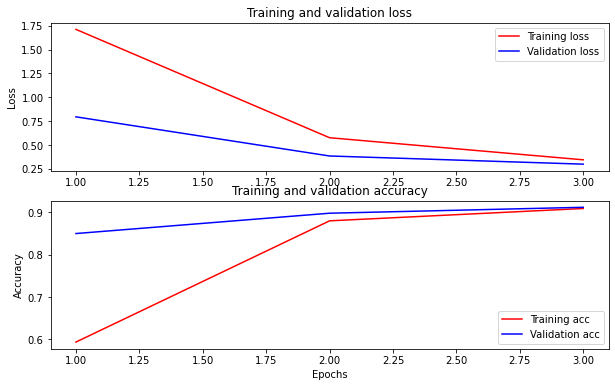

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("history.png")